# Install & Setup

In [1]:
!apt-get install -y libglib2.0-0 libsm6 libxrender1 libxext6
!pip install opencv-python matplotlib -q

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsm6 is already the newest version (2:1.2.3-1build2).
libxext6 is already the newest version (2:1.3.4-1build1).
libxrender1 is already the newest version (1:0.9.10-1build4).
libxrender1 set to manually installed.
libglib2.0-0 is already the newest version (2.72.4-0ubuntu2.4).
libglib2.0-0 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [2]:
import os
import random
import tarfile
import urllib.request
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm

In [3]:
random.seed(42)
np.random.seed(42)

# Download & Extract MPEG-7 Shape Dataset

In [4]:
DATASET_URL = "https://dabi.temple.edu/external/shape/MPEG7/MPEG7dataset.zip"
ZIP_PATH = "./mpeg7.zip"
EXTRACT_DIR = "./mpeg7"
SILHOUETTE_DIR = os.path.join(EXTRACT_DIR, "original")

In [5]:
if not os.path.exists(SILHOUETTE_DIR):
    print("Downloading MPEG-7 Dataset...")
    urllib.request.urlretrieve(DATASET_URL, ZIP_PATH)

    print("Extracting...")
    import zipfile
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
    print("Download and extraction complete.")
else:
    print("Dataset already exists.")

Extracting...
Download and extraction complete.


# Visualize Sample Silhouettes

In [6]:
!pip install imageio -q

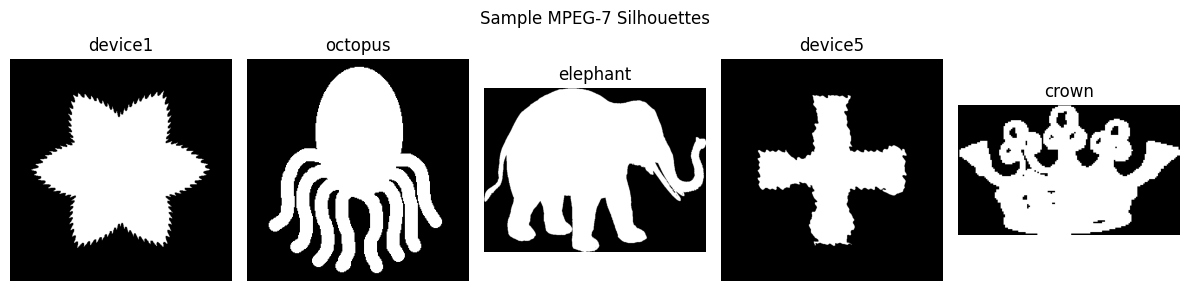

In [31]:
import imageio.v3 as iio

all_gifs = sorted(glob.glob(os.path.join(SILHOUETTE_DIR, "*.gif")))
plt.figure(figsize=(12, 3))
for i, path in enumerate(random.sample(all_gifs, 5)):
    img = iio.imread(path)[0]  # Select the first frame-
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(os.path.basename(path).split("-")[0])
    plt.axis("off")
plt.suptitle("Sample MPEG-7 Silhouettes")
plt.tight_layout()
plt.show()

# Generate Numerosity Images from Silhouettes

In [12]:
OUTPUT_DIR = "./numerosity_mpeg7"
os.makedirs(OUTPUT_DIR, exist_ok=True)

LABELS = {0: "Few", 1: "Medium", 2: "Many"}
CATEGORY_THRESHOLDS = [5, 15]  # Few: 1-5, Medium: 6-15, Many: 16-30
IMAGE_SIZE = 128
NUM_IMAGES = 3000

In [13]:
import glob
import imageio.v3 as iio

print("Loading silhouette images...")
silhouette_images = []
img_paths = glob.glob(os.path.join(SILHOUETTE_DIR, '*.gif'))
for path in img_paths:
    try:
        img = iio.imread(path)[0]
        if img is not None:
            silhouette_images.append(img)
    except Exception as e:
        print(f"Failed to read {path}: {e}")

print(f"Loaded {len(silhouette_images)} silhouettes.")

Loading silhouette images...
Loaded 1402 silhouettes.


In [14]:
# Categorize numerosity
def categorize(count):
    if count <= CATEGORY_THRESHOLDS[0]: return 0
    elif count <= CATEGORY_THRESHOLDS[1]: return 1
    else: return 2

# Composite image generator
def generate_composite():
    canvas = np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)
    num_shapes = random.randint(1, 30)

    shape = random.choice(silhouette_images)
    if len(shape.shape) > 2:
        shape = cv2.cvtColor(shape, cv2.COLOR_BGR2GRAY)

    shape = cv2.resize(shape, (random.randint(20, 40), random.randint(20, 40)))
    h, w = shape.shape

    for _ in range(num_shapes):
        x = random.randint(0, IMAGE_SIZE - w)
        y = random.randint(0, IMAGE_SIZE - h)
        roi = canvas[y:y+h, x:x+w]
        canvas[y:y+h, x:x+w] = np.maximum(roi, (shape > 127).astype(np.uint8) * 255)

    return canvas, categorize(num_shapes)
# Generate and save images
print("Generating dataset...")
for i in tqdm(range(NUM_IMAGES)):
    img, label = generate_composite()
    save_path = os.path.join(OUTPUT_DIR, f"img_{i:04d}_label_{label}.png")
    cv2.imwrite(save_path, img)
print("Numerosity dataset generation complete!")

Generating dataset...


100%|██████████| 3000/3000 [00:01<00:00, 1945.48it/s]

Numerosity dataset generation complete!


# Visualize a Sample Grid

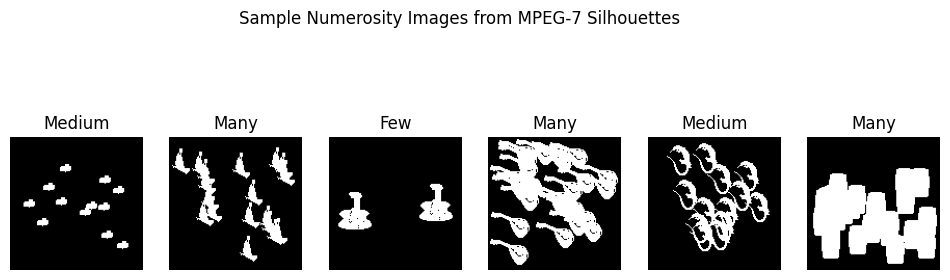

In [20]:
samples = random.sample(glob.glob(os.path.join(OUTPUT_DIR, '*.png')), 6)
plt.figure(figsize=(12, 4))
for i, path in enumerate(samples):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    label = LABELS[int(path.split('_')[-1].split('.')[0])]
    plt.subplot(1, 6, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')
plt.suptitle("Sample Numerosity Images from MPEG-7 Silhouettes")
plt.show()

# Prepare Dataset for Model

In [21]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, random_split
from PIL import Image
import os

# Step 1: Define a custom dataset
class NumerositySilhouetteDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path).convert("L")
        label = int(path.split("_")[-1].split(".")[0])
        if self.transform:
            img = self.transform(img)
        return img, label

In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),               # Converts to [C x H x W], with range [0,1]
    transforms.Normalize((0.5,), (0.5,)) # Normalize grayscale to [-1, 1]
])

In [23]:
dataset = NumerositySilhouetteDataset(OUTPUT_DIR, transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

In [32]:
torch.save(train_dataset, "train_dataset.pt")
torch.save(val_dataset, "val_dataset.pt")
torch.save(test_dataset, "test_dataset.pt")

print(f"Saved: {len(train_dataset)} train / {len(val_dataset)} val / {len(test_dataset)} test")

Saved: 2100 train / 450 val / 450 test
